In [197]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import torch.nn as nn
from torch.nn import KLDivLoss
from torch.nn.functional import interpolate
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [198]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
# Interpolating to image size used in experiments
img_tensor = interpolate(img_tensor, size=(3, 128, 128))
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape
print(img_tensor.shape)

torch.Size([16, 4, 3, 128, 128])


In [199]:
time_window = 5
patch_size = (7, 7)
hist_norm_p = float('inf')  # 0, 1, 2, float('inf')
v_min = 0.0
v_max = 1.0
n_bins = 50  # 50 / 100 / 255

In [200]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

In [201]:
class GaussianHistogram(nn.Module):
    def __init__(self, bins, min, max, sigma):
        super(GaussianHistogram, self).__init__()
        self.bins = bins
        self.min = min
        self.max = max
        self.sigma = sigma
        self.delta = float(max - min) / float(bins)
        self.centers = float(min) + self.delta * (torch.arange(bins).float() + 0.5)

    def forward(self, x):
        x = torch.unsqueeze(x, 0) - torch.unsqueeze(self.centers, 1)
        x = torch.exp(-0.5*(x/self.sigma)**2) / (self.sigma * np.sqrt(np.pi*2)) * self.delta
        x = x.sum(dim=1)
        return x

In [221]:
def differentiable_histogram(x, bins=255, min=0.0, max=1.0):

    if len(x.shape) == 4:
        n_samples, n_chns, _, _ = x.shape
    elif len(x.shape) == 2:
        n_samples, n_chns = 1, 1
    else:
        raise AssertionError('The dimension of input tensor should be 2 or 4.')

    hist_torch = torch.zeros(n_samples, n_chns, bins).to(x.device)
    delta = (max - min) / bins

    BIN_Table = torch.arange(start=0, end=bins, step=1) * delta

    for dim in range(1, bins-1, 1):
        h_r = BIN_Table[dim].item()             # h_r
        h_r_sub_1 = BIN_Table[dim - 1].item()   # h_(r-1)
        h_r_plus_1 = BIN_Table[dim + 1].item()  # h_(r+1)

        mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
        mask_plus = ((h_r_plus_1 > x) & (x >= h_r)).float()

        hist_torch[:, :, dim] += torch.sum(((x - h_r_sub_1) * mask_sub).view(n_samples, n_chns, -1), dim=-1)
        hist_torch[:, :, dim] += torch.sum(((h_r_plus_1 - x) * mask_plus).view(n_samples, n_chns, -1), dim=-1)

    # return hist_torch / delta
    return hist_torch

In [222]:
import numpy as np

gausshist = GaussianHistogram(bins=n_bins, min=0, max=patch_size[0]*patch_size[1], sigma=6)
perfect_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                #perfect_hists[n, t, k, c] = torch.histc(perfect_kpt_patches[n, t, k, c], bins=n_bins)
                #perfect_hists[n, t, k, c] = gausshist(perfect_kpt_patches[n, t, k, c].flatten())
                perfect_hists[n, t, k, c] = differentiable_histogram(perfect_kpt_patches[n, t, k, c], bins=n_bins)
                # Normalizing hists to probabilities 
                # (Each count devided by total number of counts)
                # perfect_hists[n, t, k, c] /= torch.maximum(torch.sum(perfect_hists[n, t, k, c]), torch.tensor([1.0]))

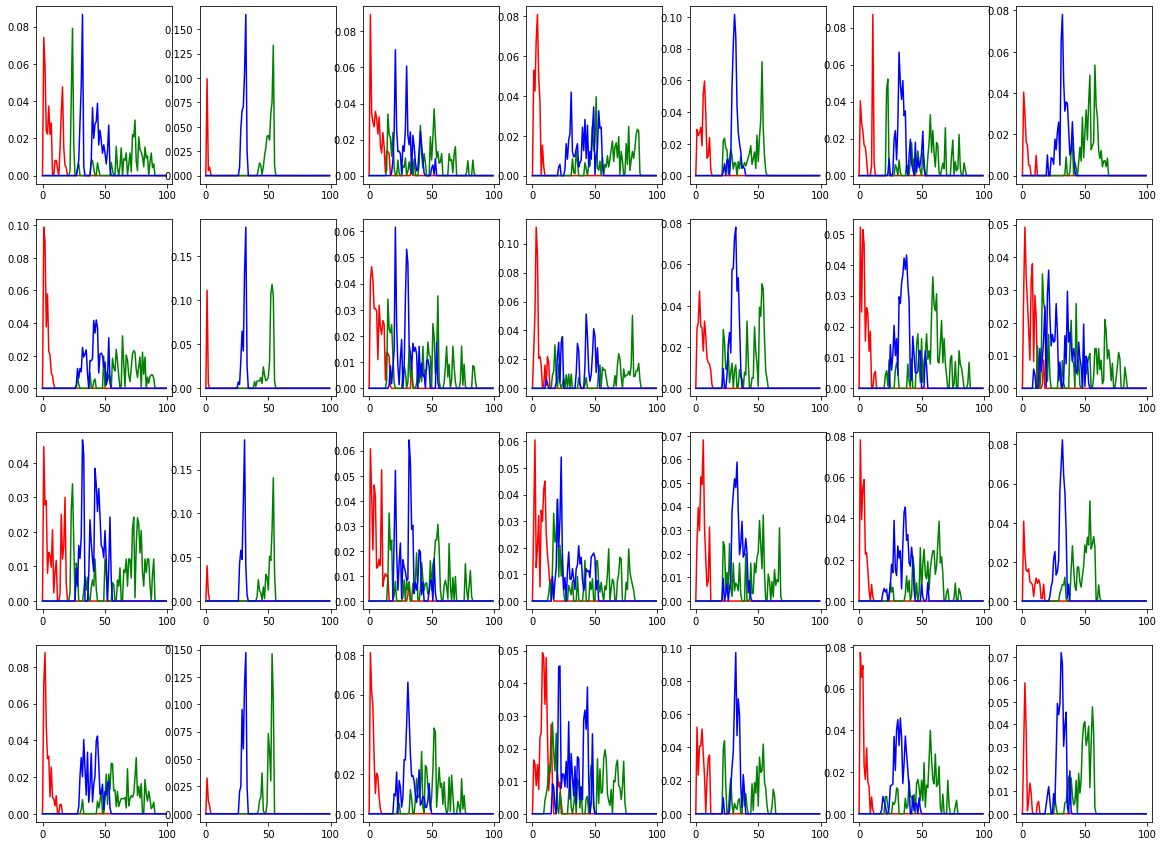

In [223]:
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_hists[0, t, k, 2], color='blue')
    

In [224]:
perfect_hists[0, 2, 1, :]

tensor([[0.0000, 0.0404, 0.0092, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0

tensor([[0.0790, 0.0431, 0.0482, 0.0431, 0.0337, 0.0871, 0.0780],
        [0.0624, 0.1427, 0.0478, 0.0988, 0.0502, 0.0304, 0.0824],
        [0.0600, 0.1076, 0.0576, 0.0463, 0.0490, 0.0357, 0.0394]])
tensor(0.0630)


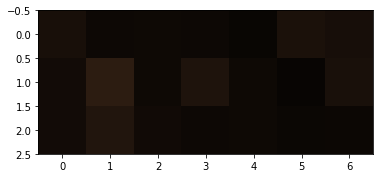

In [225]:
perfect_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_dist[k, t] = torch.norm(perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (perfect_hists[0, t:t+1, k, :] - perfect_hists[0, t+1:t+2, k, :])**2/\
            (perfect_hists[0, t:t+1, k, :] + perfect_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        perfect_dist[k, t] = torch.mean(d)
        """
        
print(perfect_dist.T)
        
plt.imshow(perfect_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_dist.mean())

In [226]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))


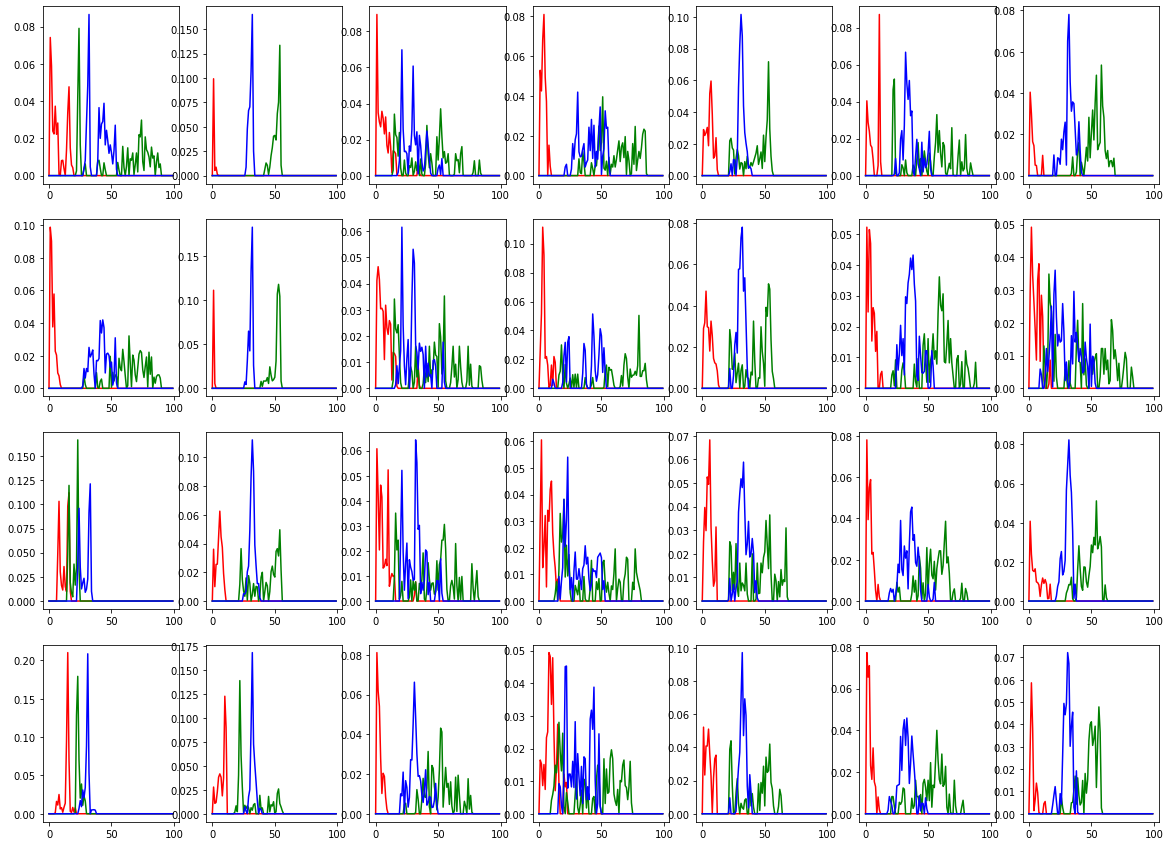

In [227]:
bad_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_hists[n, t, k, c] = differentiable_histogram(bad_kpt_patches[n, t, k, c], bins=n_bins)
                #bad_hists[n, t, k, c] /= torch.sum(bad_hists[n, t, k, c])
                bad_hists[n, t, k, c] /= torch.maximum(torch.sum(bad_hists[n, t, k, c]), torch.tensor([1.0]))

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_hists[0, t, k, 2], color='blue')

tensor([[0.0790, 0.0431, 0.0482, 0.0431, 0.0337, 0.0871, 0.0780],
        [0.1667, 0.0863, 0.0478, 0.0988, 0.0502, 0.0304, 0.0824],
        [0.1859, 0.1273, 0.0576, 0.0463, 0.0490, 0.0357, 0.0394]])
tensor(0.0722)


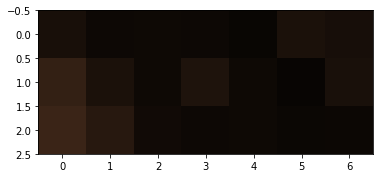

In [228]:
bad_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # bad_dist[k, t] = dkl(bad_hists[0, t:t+1, k, :], bad_hists[0, t+1:t+2, k, :])
        bad_dist[k, t] = torch.norm(bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (bad_hists[0, t:t+1, k, :] - bad_hists[0, t+1:t+2, k, :])**2/\
            (bad_hists[0, t:t+1, k, :] + bad_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        bad_dist[k, t] = torch.mean(d)
        """
        
print(bad_dist.T)
        
plt.imshow(bad_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_dist.mean())

In [229]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

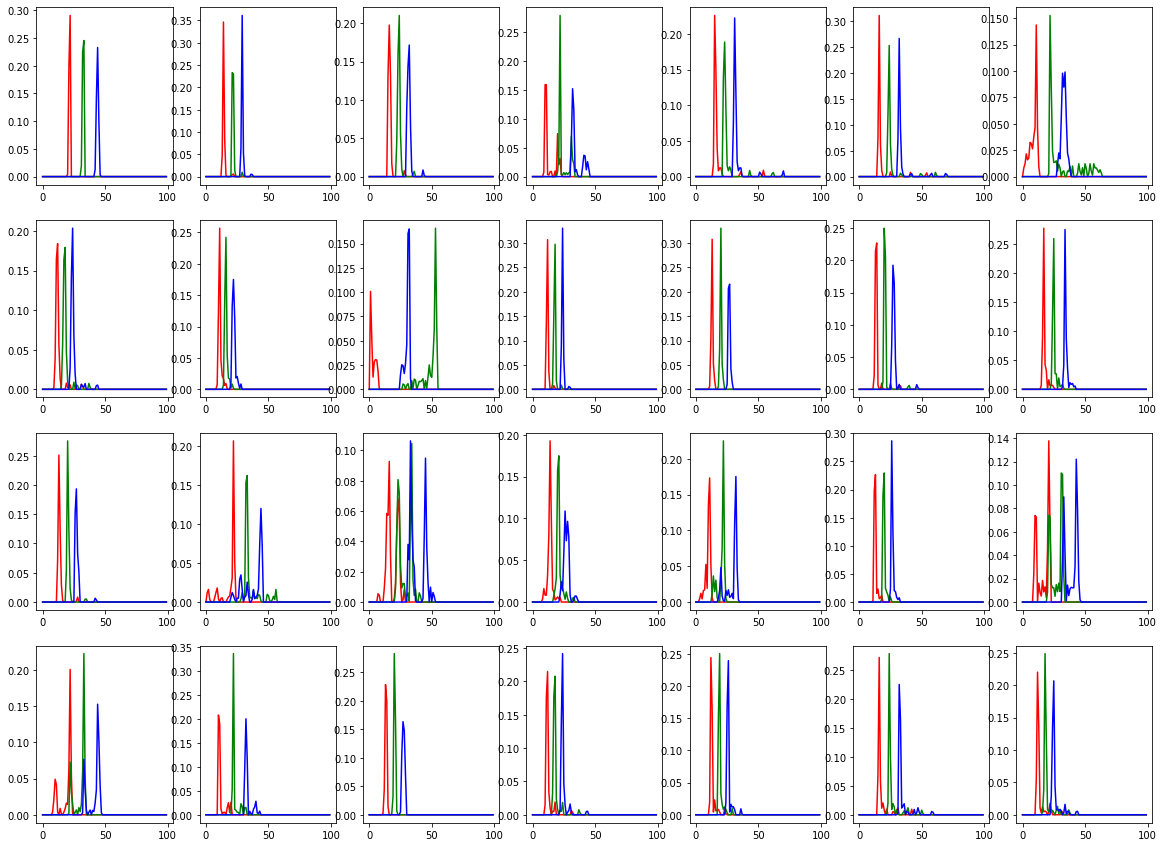

In [230]:
random_hists = torch.empty((N, T, K, C, n_bins))
for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_hists[n, t, k, c] = differentiable_histogram(random_kpt_patches[n, t, k, c], bins=n_bins)
                #random_hists[n, t, k, c] /= torch.sum(random_hists[n, t, k, c])
                random_hists[n, t, k, c] /= torch.maximum(torch.sum(random_hists[n, t, k, c]), torch.tensor([1.0]))

fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_hists[0, t, k, 2], color='blue')

tensor([[0.2851, 0.3612, 0.2102, 0.3302, 0.3306, 0.3114, 0.2776],
        [0.2649, 0.2569, 0.1659, 0.3167, 0.3024, 0.2182, 0.2690],
        [0.2753, 0.3357, 0.2831, 0.2282, 0.2506, 0.2867, 0.2488]])
tensor(0.2766)


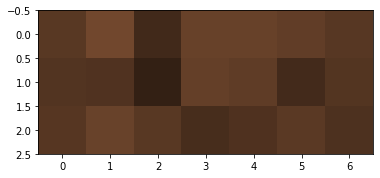

In [231]:
random_dist = torch.empty((K, T-1))

dkl = KLDivLoss(reduction='batchmean')

for k in range(K):
    for t in range(T-1):
        # random_dist[k, t] = dkl(random_hists[0, t:t+1, k, :], random_hists[0, t+1:t+2, k, :])
        random_dist[k, t] = torch.norm(random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :], p=hist_norm_p)
        """
        d = (random_hists[0, t:t+1, k, :] - random_hists[0, t+1:t+2, k, :])**2/\
            (random_hists[0, t:t+1, k, :] + random_hists[0, t+1:t+2, k, :])
        d = torch.nan_to_num(d, 0.0)
        d = torch.sum(d, dim=-1)
        random_dist[k, t] = torch.mean(d)
        """

print(random_dist.T)
        
plt.imshow(random_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_dist.mean())

Tensor based loss formulation

In [213]:
H_t_perfect = perfect_hists.unsqueeze(1) - perfect_hists.unsqueeze(2)
H_t_perfect = torch.norm(H_t_perfect, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_perfect = torch.sum(H_t_perfect, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_perfect))

tensor(0.1726)


In [214]:
H_t_bad = bad_hists.unsqueeze(1) - bad_hists.unsqueeze(2)
H_t_bad = torch.norm(H_t_bad, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_bad = torch.sum(H_t_bad, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_bad))

tensor(0.2516)


In [215]:
H_t_random = random_hists.unsqueeze(1) - random_hists.unsqueeze(2)
H_t_random = torch.norm(H_t_random, p=hist_norm_p, dim=[-1, -2]).permute(0, 3, 1, 2)
H_t_random = torch.sum(H_t_random, dim=[-1, -2]) / (T*(T-1))
print(torch.mean(H_t_random))

tensor(0.6420)
